<a href="https://colab.research.google.com/github/Miguithub/ARSUSD/blob/main/RS_GARCH_Ars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# LIBRERIAS 1

In [ ]:
!pip install statsmodels

In [ ]:
import requests
import pandas as pd
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

---

# DI

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

Mounted at /content/drive


In [ ]:
ars = pd.read_parquet('/content/drive/MyDrive/arsusd2025.parquet')

Check

In [ ]:
ars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23587200 entries, 0 to 23587199
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   close_time  int64  
 1   close       float64
 2   btc_close   float64
 3   ars         float64
dtypes: float64(3), int64(1)
memory usage: 719.8 MB


In [ ]:
ars.tail()

,close_time,close,btc_close,ars
23587195,1759276795999999,170797710.0,114048.94,1497.582617
23587196,1759276796999999,170797710.0,114048.94,1497.582617
23587197,1759276797999999,170797710.0,114048.94,1497.582617
23587198,1759276798999999,170797710.0,114048.93,1497.582748
23587199,1759276799999999,170797710.0,114048.93,1497.582748


In [ ]:
ars.head()

,close_time,close,btc_close,ars
0,1735689600999999,115192495.0,93576.01,1231.004560
1,1735689601999999,115192495.0,93576.01,1231.004560
2,1735689602999999,115192495.0,93576.00,1231.004691
3,1735689603999999,115192495.0,93576.01,1231.004560
4,1735689604999999,115192495.0,93576.00,1231.004691


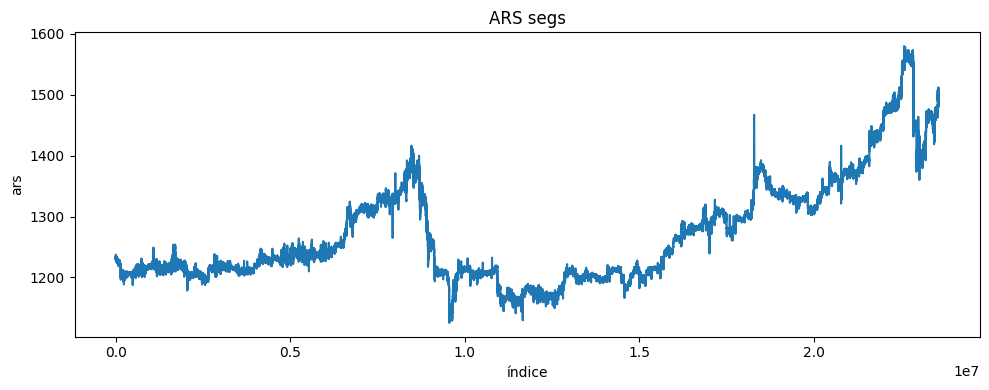

In [ ]:
import matplotlib.pyplot as plt

s = ars["ars"].astype(float).dropna()

plt.figure(figsize=(10,4))
plt.plot(s.index, s.values)
plt.title("ARS segs")
plt.xlabel("índice"); plt.ylabel("ars")
plt.tight_layout(); plt.show()

In [ ]:
ars = ars.drop(columns=["btc_close", "close"], errors="ignore")

In [ ]:
import numpy as np

float64_cols = ars.select_dtypes(include=["float64"]).columns
ars[[f"{c}_ln" for c in float64_cols]] = np.log(ars[float64_cols])

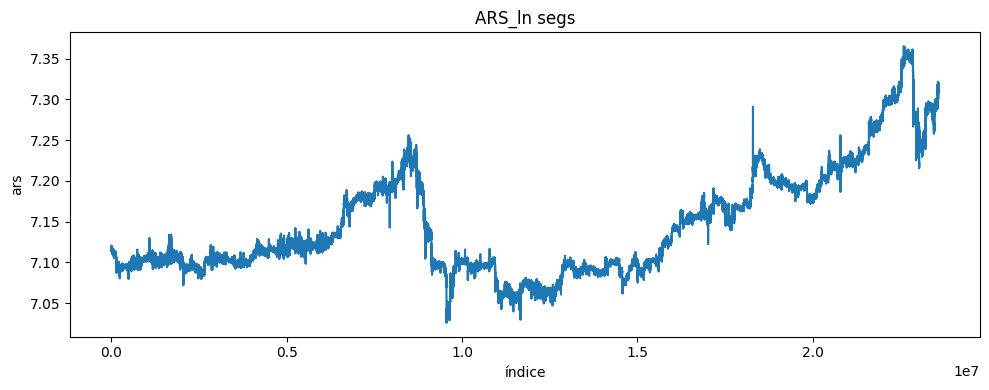

In [ ]:
import matplotlib.pyplot as plt

s = ars["ars_ln"].astype(float).dropna()

plt.figure(figsize=(10,4))
plt.plot(s.index, s.values)
plt.title("ARS_ln segs")
plt.xlabel("índice"); plt.ylabel("ars")
plt.tight_layout(); plt.show()

In [ ]:
# eth['dia'] = (((pd.to_datetime(eth['timestamp'], errors='coerce').dt.dayofweek + 1) % 7) + 1).astype('int32')
# eth['hora_str'] = eth['timestamp'].dt.strftime('%H:%M:%S')
# eth['hora_time'] = eth['timestamp'].dt.time
# eth['hour']   = eth['timestamp'].dt.hour
# eth['minute'] = eth['timestamp'].dt.minute

In [ ]:
ars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23587200 entries, 0 to 23587199
Data columns (total 3 columns):
 #   Column      Dtype  
---  ------      -----  
 0   close_time  int64  
 1   ars         float64
 2   ars_ln      float64
dtypes: float64(2), int64(1)
memory usage: 539.9 MB


In [ ]:
import numpy as np

ars_ = ars.sort_index()
ars1, ars2, ars3, ars4, ars5 = [x.copy() for x in np.array_split(ars_, 5)]

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
# ars es el valor del dolar cripto en segundo para el periodo:
#  (2025, 1, 1 ; 2025, 9, 30) que son 273 dias
# y cada ars1:ars5 representan el 20% (54.6 dias) de esto:
# Parte,Duración,Fecha y Hora de Inicio,Fecha y Hora de Fin
# 1,"4,717,440 s",01-01-2025 00:00:00,24-02-2025 15:43:59
# 2,"4,717,440 s",24-02-2025 15:44:00,20-04-2025 07:27:59
# 3,"4,717,440 s",20-04-2025 07:28:00,14-06-2025 23:11:59
# 4,"4,717,440 s",14-06-2025 23:12:00,09-08-2025 14:55:59
# 5,"4,717,440 s",09-08-2025 14:56:00,30-09-2025 23:59:59

In [ ]:
ars1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4717440 entries, 0 to 4717439
Data columns (total 3 columns):
 #   Column      Dtype  
---  ------      -----  
 0   close_time  int64  
 1   ars         float64
 2   ars_ln      float64
dtypes: float64(2), int64(1)
memory usage: 108.0 MB


In [ ]:
ars1.tail()

,close_time,ars,ars_ln
4717435,1740407035999999,1229.852899,7.114650
4717436,1740407036999999,1229.852899,7.114650
4717437,1740407037999999,1229.851739,7.114649
4717438,1740407038999999,1229.851739,7.114649
4717439,1740407039999999,1229.809992,7.114615


In [ ]:
ars1["close_ln_diff"] = ars1["ars_ln"].diff()

# Regime-Switching GARCH + Intraday Seasonality + Jump Component

##1. Prenormalización

In [ ]:
import pandas as pd
import numpy as np

ars1["sec_day"] = ars1["close_time"] % 86400
# mediana del absoluto por segundo del día
m = ars1.groupby("sec_day")["close_ln_diff"].transform(lambda x: x.abs().median())
# normalización intradía
ars1["r_norm"] = ars1["close_ln_diff"] / m

In [ ]:
# En el subsecuente ANOVA trabajamos con conjuntos de n datos para evitar
# vacios en sentido literal y de diferencias

In [ ]:
import numpy as np
from scipy.stats import f_oneway

# --- Binning intradía en bloques de 300 segundos (5 min)
BIN = 300
ars1["bin_day"] = (ars1["close_time"] % 86400) // BIN
ars1["bin_day"] = ars1["bin_day"].astype(np.int32)

# --- Construcción de grupos
groups = []
for _, g in ars1.groupby("bin_day")["r_norm"]:
    arr = g.to_numpy()
    arr = arr[np.isfinite(arr)]
    if arr.size > 1 and np.var(arr) > 0:
        groups.append(arr)

# --- ANOVA One-Way
if len(groups) < 2:
    print("No hay suficientes grupos válidos para ANOVA (todos vacíos o sin varianza).")
else:
    F_stat, p_val = f_oneway(*groups)

    alpha = 0.05
    print("ANOVA intradía sobre r_norm por bloques de 5 minutos")
    print(f"N° de grupos válidos: {len(groups)}")
    print(f"F = {F_stat:.6f}")
    print(f"p-valor = {p_val:.6e}")

    if p_val < alpha:
        print(f"Conclusión: Se rechaza H0 al {alpha*100:.0f}%. Hay estacionalidad intradía.")
    else:
        print(f"Conclusión: No se rechaza H0 al {alpha*100:.0f}%. No hay evidencia estadística fuerte de estacionalidad intradía.")

ANOVA intradía sobre r_norm por bloques de 5 minutos
N° de grupos válidos: 54
F = 1.878673
p-valor = 1.133495e-04
Conclusión: Se rechaza H0 al 5%. Hay estacionalidad intradía.


In [ ]:
# La serie tiene estacionalidad intradia estadisticamente significativa, incluso
# despues de dividir por el patro intradia inicial que ya se aplico. Esto es logico
# por el funcionamiento de cualquier economia, pues tienes horas activas, aperturas de
# bancos, horas muertas, eventos politicos que impulsan la volatilidad, entre otros...

# por lo cual vamos a aplicar un SUAVIZADO POR KERNEL DE MEDIANA LOCAL PORQUE:
# Es robusto a outliers, no destruye los regimenes locales, respeta discontinuidades suavez en hs reales
# ajusta bien en ausencia o poca presencia de datos

In [ ]:
import numpy as np

# ============================================
# 1) Bins intradía de 5 minutos
# ============================================
BIN = 300  # 5 minutos en segundos
ars1["bin_day"] = ((ars1["close_time"] % 86400) // BIN).astype(np.int32)

# ============================================
# 2) Mediana robusta de r_norm^2 por bin
# ============================================
r2 = ars1["r_norm"].to_numpy()**2
ars1["r2_norm"] = r2

y_bin = (
    ars1
    .groupby("bin_day")["r2_norm"]
    .median()
    .reindex(range(86400 // BIN), fill_value=np.nan)  # 288 bins
)

# reemplazar NaN por la mediana global
global_med = np.nanmedian(y_bin.to_numpy())
y = y_bin.to_numpy()
y[~np.isfinite(y)] = global_med

# ============================================
# 3) Suavizado kernel Epanechnikov sobre bins
# ============================================
H = 2  # half-window en bins (ajustable: 1–3)
offsets = np.arange(-H, H + 1)
u = offsets / H
weights = 0.75 * (1.0 - u**2)
weights[np.abs(u) > 1.0] = 0.0
w_sum = weights.sum()

nbins = y.shape[0]
y_smooth = np.empty_like(y)

for i in range(nbins):
    idx = (i + offsets) % nbins  # circular intradía
    y_smooth[i] = (weights * y[idx]).sum() / w_sum

# evitar ceros
y_smooth[~np.isfinite(y_smooth)] = global_med
y_smooth[y_smooth <= 0] = global_med

# sigma intradía por bin (escala)
sigma_bin = np.sqrt(y_smooth)

# mediana global de sigma para fallback
global_sigma = float(np.nanmedian(sigma_bin))

# mapear sigma intradía a cada fila según bin_day
sigma_map = dict(zip(range(nbins), sigma_bin))
ars1["intraday_sigma"] = ars1["bin_day"].map(sigma_map).astype(float)

# -----------------------------------------------
# Versión sin warnings y totalmente segura
# -----------------------------------------------
intraday = ars1["intraday_sigma"].to_numpy()

# Reemplazar ceros y NaN con global_sigma
mask_zero = intraday == 0.0
mask_nan = ~np.isfinite(intraday)
intraday[mask_zero | mask_nan] = global_sigma

ars1["intraday_sigma"] = intraday

# Retorno final desestacionalizado para RS-GARCH
ars1["r_deseason"] = ars1["r_norm"] / ars1["intraday_sigma"]

In [ ]:
import numpy as np
from scipy.stats import f_oneway

# Proxy de volatilidad desestacionalizada
ars1["r_deseason2"] = ars1["r_deseason"]**2

BIN = 300
ars1["bin_day"] = ((ars1["close_time"] % 86400) // BIN).astype(np.int32)

groups = []
for _, g in ars1.groupby("bin_day")["r_deseason2"]:
    arr = g.to_numpy()
    arr = arr[np.isfinite(arr)]
    if arr.size > 1 and np.var(arr) > 0:
        groups.append(arr)

if len(groups) < 2:
    print("No hay suficientes grupos válidos para ANOVA (todos vacíos o sin varianza).")
else:
    F_stat, p_val = f_oneway(*groups)

    alpha = 0.05
    print("ANOVA intradía sobre r_deseason^2 por bloques de 5 minutos")
    print(f"N° de grupos válidos: {len(groups)}")
    print(f"F = {F_stat:.6f}")
    print(f"p-valor = {p_val:.6e}")

    if p_val < alpha:
        print(f"Conclusión: Se rechaza H0 al {alpha*100:.0f}%. Sigue habiendo estacionalidad intradía en la VARIANZA.")
    else:
        print(f"Conclusión: No se rechaza H0 al {alpha*100:.0f}%. No hay evidencia fuerte de estacionalidad intradía en la VARIANZA.")

ANOVA intradía sobre r_deseason^2 por bloques de 5 minutos
N° de grupos válidos: 54
F = 1.318728
p-valor = 5.982047e-02
Conclusión: No se rechaza H0 al 5%. No hay evidencia fuerte de estacionalidad intradía en la VARIANZA.


Ahora pasa los test, F cayo en 30%, p paso el 0.05 y paso el test, ya se puede hacer el RS-GARCH

In [ ]:
import numpy as np
from scipy.stats import kruskal

# Proxy de volatilidad desestacionalizada
ars1["r_deseason2"] = ars1["r_deseason"]**2

BIN = 300
ars1["bin_day"] = ((ars1["close_time"] % 86400) // BIN).astype(np.int32)

# --- construir grupos por bin ---
groups = []
vars_bins = []

for _, g in ars1.groupby("bin_day")["r_deseason2"]:
    arr = g.to_numpy()
    arr = arr[np.isfinite(arr)]
    if arr.size > 1:
        v = np.var(arr)
        if v > 0:
            groups.append(arr)
            vars_bins.append(v)

print(f"N° de grupos válidos: {len(groups)}")

# --- Test 1: ratio de varianzas ---
if len(vars_bins) > 1:
    vars_bins = np.array(vars_bins)
    v_min = vars_bins.min()
    v_max = vars_bins.max()
    ratio = v_max / v_min
    print("\n== Test 1: Ratio de varianzas intradía sobre r_deseason^2 ==")
    print(f"Var mínima: {v_min:.6e}")
    print(f"Var máxima: {v_max:.6e}")
    print(f"Ratio max/min: {ratio:.4f}")
else:
    print("No hay suficientes grupos con varianza > 0 para el ratio de varianzas.")

# --- Test 2: Kruskal–Wallis ---
if len(groups) > 1:
    H_stat, p_val = kruskal(*groups)
    alpha = 0.05
    print("\n== Test 2: Kruskal–Wallis sobre r_deseason^2 por bloques de 5 min ==")
    print(f"H = {H_stat:.6f}")
    print(f"p-valor = {p_val:.6e}")
    if p_val < alpha:
        print(f"Conclusión: Se rechaza H0 al {alpha*100:.0f}%. Siguen habiendo diferencias intradía en la varianza.")
    else:
        print(f"Conclusión: No se rechaza H0 al {alpha*100:.0f}%. No hay evidencia fuerte de estacionalidad intradía en la varianza.")
else:
    print("No hay suficientes grupos válidos para Kruskal–Wallis.")

N° de grupos válidos: 54

== Test 1: Ratio de varianzas intradía sobre r_deseason^2 ==
Var mínima: 1.189647e+15
Var máxima: 1.329680e+16
Ratio max/min: 11.1771

== Test 2: Kruskal–Wallis sobre r_deseason^2 por bloques de 5 min ==
H = 509.648847
p-valor = 6.915817e-76
Conclusión: Se rechaza H0 al 5%. Siguen habiendo diferencias intradía en la varianza.


In [ ]:
# La varianza minima es apx 11 veces mas pequeña que la mayot esto lo hace inaceptable
# normalmente deberia ser como mucho 2.5 veces mas grande. Por otro lado, en el test de
# Krusal-Wallis se rechaza la hipotesis nula, siguen habiendo diferencias enormes.

# NO SE PUEDE PROSEGUIR DIRECTAMENTE CON EL RS-GARCH.

Nuevo patron intradia sobre r_deaseason

In [ ]:
# 1) bin intradía
ars1["bin_day"] = ((ars1["close_time"] % 86400) // BIN).astype(np.int32)

# 2) proxy de varianza: r_deseason^2
r2_it = ars1["r_deseason"].to_numpy()**2
ars1["r2_deseason"] = r2_it

# 3) mediana robusta por bin
y_bin_it = (
    ars1
    .groupby("bin_day")["r2_deseason"]
    .median()
    .reindex(range(86400 // BIN), fill_value=np.nan)
)

global_med_it = np.nanmedian(y_bin_it.to_numpy())
y_it = y_bin_it.to_numpy()
y_it[~np.isfinite(y_it)] = global_med_it

# 4) suavizado kernel Epanechnikov circular sobre bins
offsets = np.arange(-H, H + 1)
u = offsets / H
weights = 0.75 * (1.0 - u**2)
weights[np.abs(u) > 1.0] = 0.0
w_sum = weights.sum()

nbins = y_it.shape[0]
y_smooth_it = np.empty_like(y_it)

for i in range(nbins):
    idx = (i + offsets) % nbins
    y_smooth_it[i] = (weights * y_it[idx]).sum() / w_sum

y_smooth_it[~np.isfinite(y_smooth_it)] = global_med_it
y_smooth_it[y_smooth_it <= 0] = global_med_it

sigma_bin_it = np.sqrt(y_smooth_it)
global_sigma_it = float(np.nanmedian(sigma_bin_it))

# mapear sigma intradía iterada a cada fila
sigma_map_it = dict(zip(range(nbins), sigma_bin_it))
ars1["intraday_sigma_it"] = ars1["bin_day"].map(sigma_map_it).astype(float)

intraday_it = ars1["intraday_sigma_it"].to_numpy()
mask_zero = intraday_it == 0.0
mask_nan  = ~np.isfinite(intraday_it)
intraday_it[mask_zero | mask_nan] = global_sigma_it
ars1["intraday_sigma_it"] = intraday_it

# nueva serie desestacionalizada (iteración 1)
ars1["r_deseason_it"] = ars1["r_deseason"] / ars1["intraday_sigma_it"]

In [ ]:
# ============================================
# PASO C-D: TESTS SOBRE r_deseason_it^2
# ============================================
ars1["r_deseason_it2"] = ars1["r_deseason_it"]**2

groups = []
vars_bins = []

for _, g in ars1.groupby("bin_day")["r_deseason_it2"]:
    arr = g.to_numpy()
    arr = arr[np.isfinite(arr)]
    if arr.size > 1:
        v = np.var(arr)
        if v > 0:
            groups.append(arr)
            vars_bins.append(v)

print(f"N° de grupos válidos: {len(groups)}")

if len(vars_bins) > 1:
    vars_bins = np.array(vars_bins)
    v_min = vars_bins.min()
    v_max = vars_bins.max()
    ratio = v_max / v_min
    print("\n== Test 1 (iteración): Ratio de varianzas intradía sobre r_deseason_it^2 ==")
    print(f"Var mínima: {v_min:.6e}")
    print(f"Var máxima: {v_max:.6e}")
    print(f"Ratio max/min: {ratio:.4f}")
else:
    print("No hay suficientes grupos con varianza > 0 para el ratio de varianzas (iteración).")

if len(groups) > 1:
    H_stat, p_val = kruskal(*groups)
    alpha = 0.05
    print("\n== Test 2 (iteración): Kruskal–Wallis sobre r_deseason_it^2 por bloques de 5 min ==")
    print(f"H = {H_stat:.6f}")
    print(f"p-valor = {p_val:.6e}")
    if p_val < alpha:
        print(f"Conclusión: Se rechaza H0 al {alpha*100:.0f}%. Siguen habiendo diferencias intradía en la varianza (iteración).")
    else:
        print(f"Conclusión: No se rechaza H0 al {alpha*100:.0f}%. No hay evidencia fuerte de estacionalidad intradía en la varianza (iteración).")
else:
    print("No hay suficientes grupos válidos para Kruskal–Wallis (iteración).")

N° de grupos válidos: 54

== Test 1 (iteración): Ratio de varianzas intradía sobre r_deseason_it^2 ==
Var mínima: 1.189647e+15
Var máxima: 1.329680e+16
Ratio max/min: 11.1771

== Test 2 (iteración): Kruskal–Wallis sobre r_deseason_it^2 por bloques de 5 min ==
H = 509.648846
p-valor = 6.915820e-76
Conclusión: Se rechaza H0 al 5%. Siguen habiendo diferencias intradía en la varianza (iteración).


In [ ]:
print(ars1["intraday_sigma_it"].min(), ars1["intraday_sigma_it"].max())


0.9999999999971271 1.000000000193625


In [ ]:
import numpy as np
from statsmodels.stats.diagnostic import het_arch

# ============================
# ARCH-LM sobre r_deseason
# ============================

# Serie base (aseguramos float y finitos)
r = ars1["r_deseason"].to_numpy(dtype=float)
r[~np.isfinite(r)] = 0.0

# Orden del test (número de rezagos de r^2)
q = 20  # ajustable

# El test de ARCH se aplica sobre "residuos"; acá usamos r_deseason como tal
lm_stat, lm_pval, f_stat, f_pval = het_arch(r, maxlag=q)

print("=== Test ARCH-LM sobre r_deseason ===")
print(f"N observaciones: {r.size}")
print(f"Orden (maxlag) q = {q}")
print("\n--- Estadístico LM ---")
print(f"LM stat  = {lm_stat:.6f}")
print(f"LM p-val = {lm_pval:.6e}")
print("\n--- Estadístico F ---")
print(f"F stat   = {f_stat:.6f}")
print(f"F p-val  = {f_pval:.6e}")

alpha = 0.05
if lm_pval < alpha:
    print(f"\nConclusión (LM): Se rechaza H0 al {alpha*100:.0f}%. Hay evidencia de efectos ARCH → heterocedasticidad condicional.")
else:
    print(f"\nConclusión (LM): No se rechaza H0 al {alpha*100:.0f}%. No hay evidencia fuerte de efectos ARCH.")

if f_pval < alpha:
    print(f"Conclusión (F): Se rechaza H0 al {alpha*100:.0f}%. El modelo GARCH tiene sentido sobre r_deseason.")
else:
    print(f"Conclusión (F): No se rechaza H0 al {alpha*100:.0f}%. La evidencia de ARCH no es fuerte según el F-test.")

/tmp/ipython-input-2799954596.py:16: FutureWarning: the 'maxlag' keyword is deprecated, use 'nlags' instead.
  lm_stat, lm_pval, f_stat, f_pval = het_arch(r, maxlag=q)


=== Test ARCH-LM sobre r_deseason ===
N observaciones: 4717440
Orden (maxlag) q = 20

--- Estadístico LM ---
LM stat  = 46482.153229
LM p-val = 0.000000e+00

--- Estadístico F ---
F stat   = 2347.225229
F p-val  = 0.000000e+00

Conclusión (LM): Se rechaza H0 al 5%. Hay evidencia de efectos ARCH → heterocedasticidad condicional.
Conclusión (F): Se rechaza H0 al 5%. El modelo GARCH tiene sentido sobre r_deseason.


Hay heterocedasticidad condicional muy fuerte en r_deseason.
Tiene total sentido estimar un Regime-Switching GARCH(3).

## RS - GARCH (p,q)

In [ ]:
ars1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4717440 entries, 0 to 4717439
Data columns (total 18 columns):
 #   Column              Dtype  
---  ------              -----  
 0   close_time          int64  
 1   ars                 float64
 2   ars_ln              float64
 3   close_ln_diff       float64
 4   sec_day             int64  
 5   r_norm              float64
 6   bin_day             int32  
 7   r2_norm             float64
 8   intraday_sigma      float64
 9   r_deseason          float64
 10  r_deseason2         float64
 11  r2_deseason         float64
 12  intraday_sigma_it   float64
 13  r_deseason_it       float64
 14  r_deseason_it2      float64
 15  intraday_scale_mad  float64
 16  r_deseason_mad      float64
 17  r_deseason_mad2     float64
dtypes: float64(15), int32(1), int64(2)
memory usage: 629.8 MB


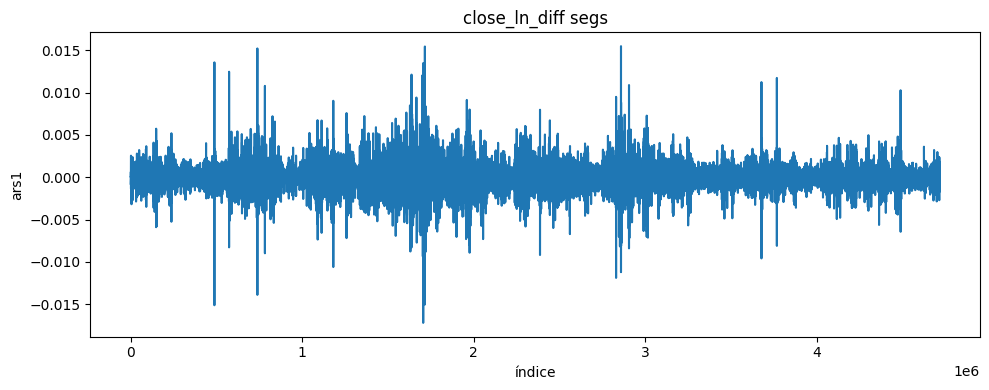

In [ ]:
import matplotlib.pyplot as plt

s = ars1["close_ln_diff"].astype(float).dropna()

plt.figure(figsize=(10,4))
plt.plot(s.index, s.values)
plt.title("close_ln_diff segs")
plt.xlabel("índice"); plt.ylabel("ars1")
plt.tight_layout(); plt.show()

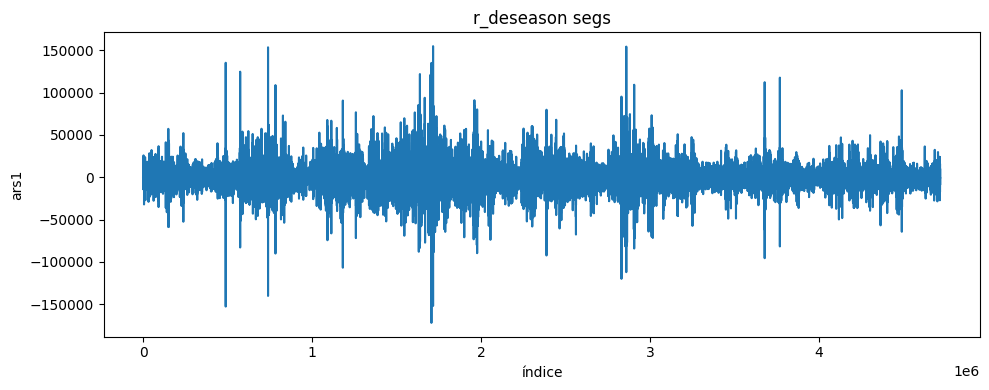

In [ ]:
import matplotlib.pyplot as plt

s = ars1["r_deseason"].astype(float).dropna()

plt.figure(figsize=(10,4))
plt.plot(s.index, s.values)
plt.title("r_deseason segs")
plt.xlabel("índice"); plt.ylabel("ars1")
plt.tight_layout(); plt.show()

p = # de términos ARCH (impacto del retorno pasado).
→ mide cómo responde la varianza al “shock” reciente.

q = # de términos GARCH (persistencia en la varianza).
→ mide cómo la volatilidad pasada arrastra a la actual.

In [ ]:
# -------------------
# 1. Barrido incial
# -------------------

# Estimamos 4 modelos: (p,q) E 1,2
# Definimos cual es el mejor segun la minimizacion de BIC (Shwarz) y AIC en seugnda instancia

In [ ]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 11.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from arch import arch_model

# ===============================
# Serie base
# ===============================
r = ars1["r_deseason"].to_numpy(dtype=float)
r[~np.isfinite(r)] = 0.0

# Opcional: centrar
r = r - r.mean()

# ===============================
# Barrido GARCH(p,q), p,q ∈ {1,2}
# ===============================
results = []

for p in [1, 2]:
    for q in [1, 2]:
        try:
            am = arch_model(
                r,
                mean="zero",      # ya centramos, no modelamos media
                vol="GARCH",
                p=p,
                q=q,
                dist="t"
            )
            res = am.fit(disp="off")
            results.append({
                "p": p,
                "q": q,
                "aic": res.aic,
                "bic": res.bic,
                "loglik": res.loglikelihood
            })
        except Exception as e:
            print(f"Falló GARCH({p},{q}): {e}")

# ===============================
# Resumen ordenado por BIC
# ===============================
df_models = pd.DataFrame(results)
df_models_sorted = df_models.sort_values("bic").reset_index(drop=True)

print("=== Modelos GARCH(p,q) sobre r_deseason (dist = t) ===")
print(df_models_sorted)

best = df_models_sorted.iloc[0]
print("\n>> Mejor por BIC: GARCH({},{})  AIC={:.4f}  BIC={:.4f}".format(
    best["p"], best["q"], best["aic"], best["bic"]
))

/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.287e+06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/tmp/ipython-input-408623002.py:30: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  res = am.fit(disp="off")
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.287e+06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescal

=== Modelos GARCH(p,q) sobre r_deseason (dist = t) ===
   p  q           aic           bic        loglik
0  1  1  6.381100e+07  6.381105e+07 -3.190549e+07
1  2  2  6.381115e+07  6.381124e+07 -3.190557e+07
2  2  1  7.447350e+07  7.447356e+07 -3.723674e+07
3  1  2  7.456575e+07  7.456582e+07 -3.728287e+07

>> Mejor por BIC: GARCH(1.0,1.0)  AIC=63810997.4965  BIC=63811050.9636


In [ ]:
# MODELOS DE MEJOR A PEOR:
#GARCH(1,1), GARCH(2,2), GARCH(2,1), GARCH(1,2)

RS GARCH(1,1)

In [ ]:
import numpy as np
from scipy.special import gammaln
from scipy.optimize import minimize

# ===============================
# 1) Serie base (re-escalada)
# ===============================
r = ars1["r_deseason"].to_numpy(dtype=float)
r[~np.isfinite(r)] = 0.0
r = r - r.mean()

scale_y = 0.01  # recomendado por arch
r_scaled = r * scale_y
T = r_scaled.size

# ===============================
# 2) Helpers de transformaciones
# ===============================

def inv_logit(x):
    return 1.0 / (1.0 + np.exp(-x))

def build_garch_params(theta_g):
    """
    theta_g: longitud 9 -> (omega_k, alpha_k, beta_k) para k=0,1,2
    Devuelve arrays omega, alpha, beta (shape (3,))
    Restringe: omega>0, alpha>=0, beta>=0, alpha+beta<0.999
    """
    eps = 1e-3
    omega = np.exp(theta_g[0:3])  # >0
    a_raw = theta_g[3:6]
    b_raw = theta_g[6:9]

    alpha = np.empty(3)
    beta  = np.empty(3)
    for k in range(3):
        a = inv_logit(a_raw[k])  # (0,1)
        b = inv_logit(b_raw[k])  # (0,1)
        # forzar alpha+beta <= 1-eps
        s = a + b
        if s >= 1.0 - eps:
            a = a * (1.0 - eps) / (s + 1e-12)
            b = b * (1.0 - eps) / (s + 1e-12)
        alpha[k] = a
        beta[k]  = b
    return omega, alpha, beta

def build_P(theta_p):
    """
    theta_p: longitud 9 (3 filas x 3 columnas)
    Se transforma fila a fila con softmax -> matriz de transición 3x3
    """
    M = theta_p.reshape(3, 3)
    M = np.exp(M - M.max(axis=1, keepdims=True))  # estabilidad
    P = M / M.sum(axis=1, keepdims=True)
    return P

def build_nu(theta_nu):
    """
    theta_nu: escalar
    nu > 4 para var finita; usamos 4 + exp()
    """
    return 4.0 + np.exp(theta_nu)

def stationary_dist(P):
    """
    Distribución estacionaria de P (3x3) vía eigenvector asociado a autovalor 1
    """
    vals, vecs = np.linalg.eig(P.T)
    idx = np.argmin(np.abs(vals - 1.0))
    v = np.real(vecs[:, idx])
    v = np.maximum(v, 0.0)
    pi = v / v.sum()
    return pi

# ===============================
# 3) Densidad t-Student
# ===============================

def student_t_logpdf(x, nu, sigma2):
    """
    x: escalar o array
    nu: grados de libertad
    sigma2: varianza condicional (misma shape que x)
    """
    # t estandarizada con var = nu/(nu-2); reescalamos para var=1
    c = gammaln((nu + 1.0) / 2.0) - gammaln(nu / 2.0) - 0.5 * np.log((nu - 2.0) * np.pi)
    z2 = x * x / sigma2
    logdens = c - 0.5 * np.log(sigma2) - (nu + 1.0) / 2.0 * np.log(1.0 + z2 / (nu - 2.0))
    return logdens

# ===============================
# 4) Log-likelihood RS-GARCH(3)
# ===============================

def rs_garch_nll(theta, r):
    """
    theta: vector de parámetros
      [0:9]   -> garch params (3*(omega,alpha,beta))
      [9:18]  -> P params (3x3 sin restricciones previas)
      [18]    -> nu param
    r: serie 1D (r_scaled)
    Devuelve: negative log-likelihood
    """
    theta_g = theta[0:9]
    theta_p = theta[9:18]
    theta_nu = theta[18]

    omega, alpha, beta = build_garch_params(theta_g)
    P = build_P(theta_p)
    nu = build_nu(theta_nu)

    # inicialización
    K = 3
    T = r.size

    # var incondicional por régimen
    sigma2 = np.empty((T, K))
    for k in range(K):
        denom = 1.0 - alpha[k] - beta[k]
        if denom <= 1e-6:
            return 1e10  # penalizar parámetros casi no estacionarios
        sigma2[0, k] = omega[k] / denom

    pi0 = stationary_dist(P)
    xi_prev = pi0  # probs filtradas t=0

    loglik = 0.0

    # filtro de Hamilton aproximado
    for t in range(T):
        rt = r[t]

        # logdens por régimen
        logf_k = student_t_logpdf(rt, nu, sigma2[t, :])
        # densidad en nivel
        f_k = np.exp(logf_k - logf_k.max())  # para estabilidad
        # predicción de régimen
        if t == 0:
            xi_pred = xi_prev
        else:
            xi_pred = xi_prev @ P  # (1x3) @ (3x3)

        num = xi_pred * f_k
        denom = num.sum()
        if denom <= 0 or not np.isfinite(denom):
            return 1e10

        loglik += np.log(denom) + logf_k.max()

        xi_post = num / denom
        xi_prev = xi_post

        # actualizar sigma2 para t+1 (si no estamos al final)
        if t < T - 1:
            for k in range(K):
                sigma2[t + 1, k] = omega[k] + alpha[k] * rt * rt + beta[k] * sigma2[t, k]

    return -loglik  # negative log-likelihood

# ===============================
# 5) Inicialización y optimización
# ===============================

# Inicialización razonable:
# - omega ~ var(r)*(1-alpha-beta)*(algo chico)
# - alpha ~ 0.05, beta ~ 0.9
var_r = np.var(r_scaled)
omega0 = np.array([0.1, 0.5, 1.0]) * var_r * 0.01
alpha0 = np.array([0.05, 0.10, 0.15])
beta0  = np.array([0.90, 0.85, 0.80])

theta_g0 = np.concatenate([
    np.log(omega0),
    np.log(alpha0 / (1 - alpha0)),  # inv-logit
    np.log(beta0 / (1 - beta0))
])

# matriz de transición inicial: diagonal fuerte
P0 = np.array([[0.97, 0.02, 0.01],
               [0.02, 0.95, 0.03],
               [0.01, 0.04, 0.95]])
theta_p0 = np.log(P0)  # softmax los re-normaliza

theta_nu0 = np.log(10.0 - 4.0)  # nu0 ~ 10

theta0 = np.concatenate([theta_g0, theta_p0.ravel(), np.array([theta_nu0])])

print("Dim theta:", theta0.size)  # debería ser 19

res = minimize(
    rs_garch_nll,
    theta0,
    args=(r_scaled,),
    method="L-BFGS-B",
    options={"maxiter": 200, "disp": True}
)

theta_hat = res.x
nll_hat = res.fun

# ===============================
# 6) Reconstruir parámetros estimados
# ===============================

theta_g_hat = theta_hat[0:9]
theta_p_hat = theta_hat[9:18]
theta_nu_hat = theta_hat[18]

omega_hat, alpha_hat, beta_hat = build_garch_params(theta_g_hat)
P_hat = build_P(theta_p_hat)
nu_hat = build_nu(theta_nu_hat)
pi_hat = stationary_dist(P_hat)

# Duración esperada por régimen
durations = 1.0 / (1.0 - np.diag(P_hat))

# Persistencia por régimen
persist = alpha_hat + beta_hat

# AIC / BIC
k_params = theta_hat.size
loglik_hat = -nll_hat
aic = 2 * k_params - 2 * loglik_hat
bic = np.log(T) * k_params - 2 * loglik_hat

# ===============================
# 7) Print de los estadísticos clave
# ===============================

np.set_printoptions(precision=6, suppress=True)

print("\n=== RS-GARCH(1,1) con 3 regímenes (t-Student, nu común) ===")
print(f"Convergió: {res.success}, mensaje: {res.message}")
print(f"Log-Likelihood: {loglik_hat:.4f}")
print(f"AIC: {aic:.4f}")
print(f"BIC: {bic:.4f}")
print(f"nu (grados de libertad): {nu_hat:.4f}")

for k in range(3):
    denom = 1.0 - alpha_hat[k] - beta_hat[k]
    unc_var = omega_hat[k] / denom if denom > 0 else np.nan
    unc_sigma = np.sqrt(unc_var) if np.isfinite(unc_var) and unc_var > 0 else np.nan
    print(f"\n-- Régimen {k+1} --")
    print(f"omega_{k+1}: {omega_hat[k]:.6e}")
    print(f"alpha_{k+1}: {alpha_hat[k]:.6f}")
    print(f"beta_{k+1}:  {beta_hat[k]:.6f}")
    print(f"alpha+beta:  {persist[k]:.6f}")
    print(f"Var incondicional: {unc_var:.6e}")
    print(f"Sigma incondicional: {unc_sigma:.6e}")
    print(f"Duración esperada (segundos): {durations[k]:.2f}")
    print(f"Prob. estacionaria pi_{k+1}: {pi_hat[k]:.4f}")

print("\nMatriz de transición P estimada:")
print(P_hat)

Dim theta: 19


/tmp/ipython-input-1663876572.py:191: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  res = minimize(
/tmp/ipython-input-1663876572.py:73: RuntimeWarning: invalid value encountered in divide
  pi = v / v.sum()


DADO EL TAMAÑO DE MUESTREO LA CONSIDERACION DE ESTE METODO, POR LO MENOS EN DINAMICA DE SEGUNDOS ES INVIABLE, Y DEBE MODELIZARSE OPTIMAMENTE CON C++. LA CPU NO PUEDE AYUDAR PUES ES EL METODO ESCONDE UNA CADENA DE MARKOV, QUE HACE INVIABLE EL ESTUDIO